# Improved balance data


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import data
from dataset import rdDataset
from model import rdcnn_2
from math import log10

import dataset
import importlib 
importlib.reload(dataset)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# cudnn.benchmark = True
path = './data'

# Parameters

params = {'test_split': .25,
          'shuffle_dataset': True,
          'batchsize': 32,
          'testBatchsize': 10,
          'random_seed': 42,
          'numworkers':32}
max_epoches = 100
learning_rate = 1e-3
drop_rate = 0.0

print('===> Loading datasets')
# Load All Dataset
dataset = rdDataset(path)

# Creating data indices for training and validation splits:
training_data_loader, testing_data_loader = data.DatasetSplit(dataset, **params)

print('===> Building model')
model = rdcnn_2(drop_rate).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)



def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)
        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

#         print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(training_data_loader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(training_data_loader)))
    return epoch, epoch_loss / len(training_data_loader)
    
def test():
    avg_error = 0
    avg_loss = 0
    with torch.no_grad():
        for batch in testing_data_loader:
            input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

            prediction = model(input)
            tmp_error = 0
#             print(len(prediction))
            for j in range(len(prediction)):
                tmp_error += torch.mean((prediction[j]-target[j])**2/torch.max(target[j]))
            avg_error += tmp_error / len(prediction)
            mse = criterion(prediction, target)
            avg_loss += mse
    print("===> Avg. Loss: {:.4f} ".format(avg_loss / len(testing_data_loader)))
    print("===> Avg. Error: {:.4f} ".format(avg_error / len(testing_data_loader)))
    return avg_loss / len(testing_data_loader),avg_error / len(testing_data_loader)

def checkpoint(epoch):
    model_out_path = "./checkpoint_largedata5/model_epoch_{}.pth".format(epoch)
    torch.save(model, model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
    

===> Loading datasets
===> Building model


In [2]:
L_train_loss = []
L_test_loss = []
L_test_error = []
for epoch in range(1, max_epoches + 1):
    train_loss = train(epoch)
    test_loss,test_error = test()
    checkpoint(epoch)
#     data.TestErrorPlot(model,device, testing_data_loader)
    L_train_loss.append(train_loss)
    L_test_loss.append(test_loss)
    L_test_error.append(test_error)

KeyboardInterrupt: 

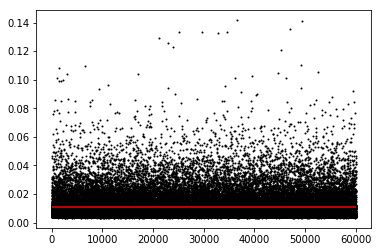

In [6]:
import importlib 
importlib.reload(data)
data.TestErrorPlot(model,device, testing_data_loader)

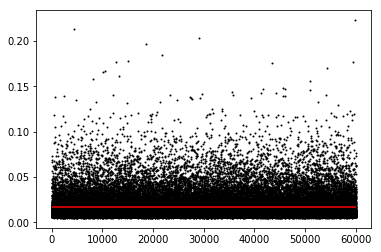

0.01628956923581316


In [15]:
import importlib 
importlib.reload(data)
data.TestErrorPlot(model,device, testing_data_loader)

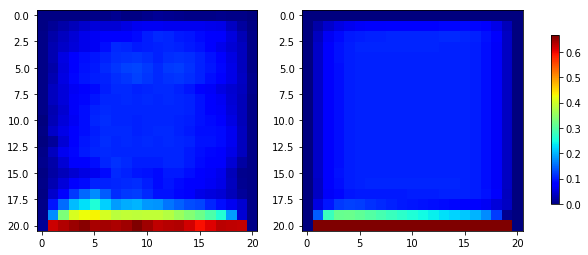

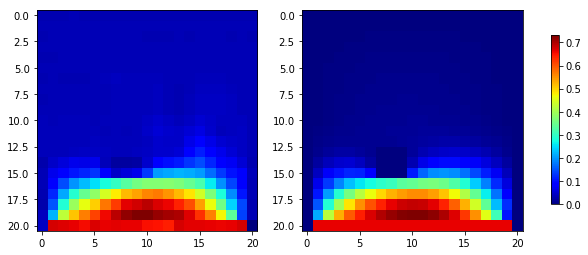

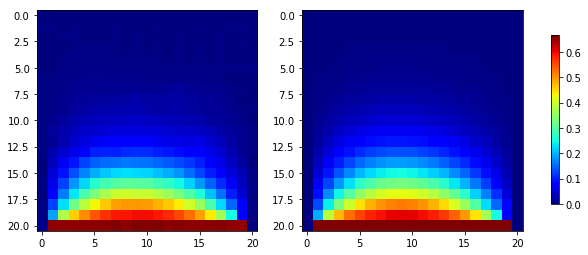

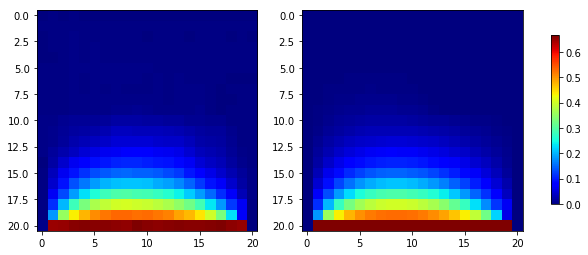

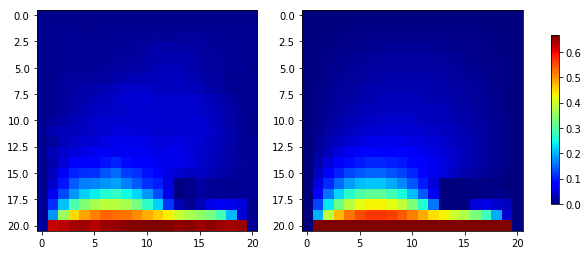

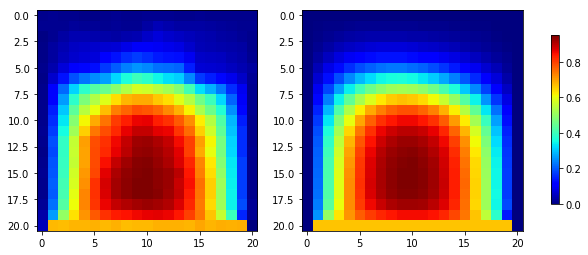

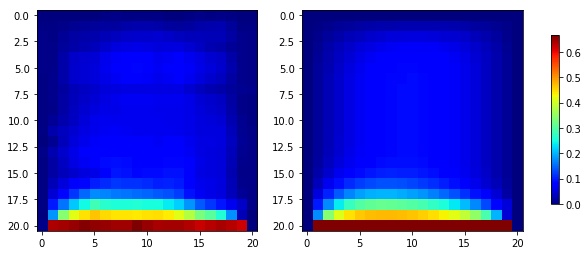

In [7]:
from matplotlib import pyplot as plt
with torch.no_grad():
    for batch in testing_data_loader:
        input, target = batch[0].to(device, torch.float), batch[1].to(device, torch.float)

        prediction = model(input)
        
for t in range(len(prediction)):
    fig, ax = plt.subplots(1,2, figsize=(10,5))

    im = ax[0].imshow(prediction[t][0].cpu(),cmap = "jet")
    im = ax[1].imshow(target[t][0].cpu(),cmap = "jet")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.84, 0.27, 0.01, 0.47])
    fig.colorbar(im, cax=cbar_ax)

plt.show()